In [1]:
import numpy as np
import pandas as pd
from io import StringIO
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchtext
from transformers import BertTokenizer, AdamW
from transformers.models.bert.modeling_bert import BertModel

/home/swietjak/mgr/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('data/data_bcr_clinical_data_sample.txt', 'r') as f:
	bcr_sample_df = pd.read_csv(StringIO(''.join(f.readlines()[4:]).replace('[Not Available]', '')), sep='\t')
	print(bcr_sample_df.columns)

Index(['PATIENT_ID', 'SAMPLE_ID', 'OTHER_SAMPLE_ID', 'SPECIMEN_CURRENT_WEIGHT',
       'DAYS_TO_COLLECTION', 'DAYS_TO_SPECIMEN_COLLECTION',
       'SPECIMEN_FREEZING_METHOD', 'INITIAL_WEIGHT',
       'SPECIMEN_SECOND_LONGEST_DIMENSION', 'IS_FFPE', 'LONGEST_DIMENSION',
       'METHOD_OF_SAMPLE_PROCUREMENT', 'OCT_EMBEDDED',
       'OTHER_METHOD_OF_SAMPLE_PROCUREMENT', 'PATHOLOGY_REPORT_FILE_NAME',
       'PATHOLOGY_REPORT_UUID', 'SAMPLE_TYPE', 'SAMPLE_TYPE_ID',
       'SHORTEST_DIMENSION', 'TIME_BETWEEN_CLAMPING_AND_FREEZING',
       'TIME_BETWEEN_EXCISION_AND_FREEZING', 'VIAL_NUMBER', 'ONCOTREE_CODE',
       'CANCER_TYPE', 'CANCER_TYPE_DETAILED'],
      dtype='object')


In [3]:
with open('data/data_bcr_clinical_data_patient 1.txt', 'r') as f:
	bcr_patient_df = pd.read_csv(StringIO(''.join(f.readlines()[4:]).replace('[Not Available]', '')), sep='\t')
	for col in bcr_patient_df.columns:
		print(col)
     

OTHER_PATIENT_ID
PATIENT_ID
FORM_COMPLETION_DATE
PROSPECTIVE_COLLECTION
RETROSPECTIVE_COLLECTION
DAYS_TO_BIRTH
GENDER
MENOPAUSE_STATUS
RACE
ETHNICITY
HISTORY_OTHER_MALIGNANCY
HISTORY_NEOADJUVANT_TRTYN
TUMOR_STATUS
VITAL_STATUS
DAYS_TO_LAST_FOLLOWUP
DAYS_TO_DEATH
RADIATION_TREATMENT_ADJUVANT
PHARMACEUTICAL_TX_ADJUVANT
HISTOLOGICAL_SUBTYPE
INITIAL_PATHOLOGIC_DX_YEAR
AGE
METHOD_OF_INITIAL_SAMPLE_PROCUREMENT
METHOD_OF_INITIAL_SAMPLE_PROCUREMENT_OTHER
SURGICAL_PROCEDURE_FIRST
FIRST_SURGICAL_PROCEDURE_OTHER
PATH_MARGIN
SURGERY_FOR_POSITIVE_MARGINS
SURGERY_FOR_POSITIVE_MARGINS_OTHER
MARGIN_STATUS_REEXCISION
STAGING_SYSTEM
STAGING_SYSTEM_OTHER
MICROMET_DETECTION_BY_IHC
LYMPH_NODES_EXAMINED
LYMPH_NODE_EXAMINED_COUNT
LYMPH_NODES_EXAMINED_HE_COUNT
LYMPH_NODES_EXAMINED_IHC_COUNT
AJCC_STAGING_EDITION
AJCC_TUMOR_PATHOLOGIC_PT
AJCC_NODES_PATHOLOGIC_PN
AJCC_METASTASIS_PATHOLOGIC_PM
AJCC_PATHOLOGIC_TUMOR_STAGE
METASTATIC_SITE
METASTATIC_SITE_OTHER
ER_STATUS_BY_IHC
ER_STATUS_IHC_PERCENT_POSITIVE
ER_POSI

In [4]:
for i, o in enumerate(bcr_patient_df.isna().sum()):
    print(bcr_patient_df.columns[i], o)

OTHER_PATIENT_ID 0
PATIENT_ID 0
FORM_COMPLETION_DATE 0
PROSPECTIVE_COLLECTION 4
RETROSPECTIVE_COLLECTION 4
DAYS_TO_BIRTH 16
GENDER 0
MENOPAUSE_STATUS 90
RACE 95
ETHNICITY 174
HISTORY_OTHER_MALIGNANCY 0
HISTORY_NEOADJUVANT_TRTYN 1
TUMOR_STATUS 125
VITAL_STATUS 0
DAYS_TO_LAST_FOLLOWUP 105
DAYS_TO_DEATH 0
RADIATION_TREATMENT_ADJUVANT 931
PHARMACEUTICAL_TX_ADJUVANT 932
HISTOLOGICAL_SUBTYPE 0
INITIAL_PATHOLOGIC_DX_YEAR 2
AGE 1
METHOD_OF_INITIAL_SAMPLE_PROCUREMENT 95
METHOD_OF_INITIAL_SAMPLE_PROCUREMENT_OTHER 4
SURGICAL_PROCEDURE_FIRST 54
FIRST_SURGICAL_PROCEDURE_OTHER 821
PATH_MARGIN 68
SURGERY_FOR_POSITIVE_MARGINS 1041
SURGERY_FOR_POSITIVE_MARGINS_OTHER 0
MARGIN_STATUS_REEXCISION 1037
STAGING_SYSTEM 216
STAGING_SYSTEM_OTHER 1076
MICROMET_DETECTION_BY_IHC 367
LYMPH_NODES_EXAMINED 377
LYMPH_NODE_EXAMINED_COUNT 126
LYMPH_NODES_EXAMINED_HE_COUNT 168
LYMPH_NODES_EXAMINED_IHC_COUNT 751
AJCC_STAGING_EDITION 141
AJCC_TUMOR_PATHOLOGIC_PT 0
AJCC_NODES_PATHOLOGIC_PN 0
AJCC_METASTASIS_PATHOLOGIC_PM 0


In [5]:
bcr_patient_df['NTE_HER2_STATUS'].value_counts()

NTE_HER2_STATUS
Negative     8
Equivocal    1
Name: count, dtype: int64

In [6]:
# print(bcr_patient_df[bcr_patient_df['PR_STATUS_BY_IHC'].isna() == True]['NTE_PR_STATUS_BY_IHC'])
print('IHC_HER2\n', bcr_patient_df['IHC_HER2'].value_counts(), '\n')
print('PR_STATUS_BY_IHC\n', bcr_patient_df['PR_STATUS_BY_IHC'].value_counts(), '\n')
print('ER_STATUS_BY_IHC\n', bcr_patient_df['ER_STATUS_BY_IHC'].value_counts(), '\n')
print('ER_STATUS_BY_IHC\n', bcr_patient_df['NTE_PR_STATUS_BY_IHC'].value_counts(), '\n')
print('HER2_FISH_STATUS\n', bcr_patient_df['HER2_FISH_STATUS'].value_counts(), '\n')

IHC_HER2
 IHC_HER2
Negative         563
Equivocal        179
Positive         164
Indeterminate     12
Name: count, dtype: int64 

PR_STATUS_BY_IHC
 PR_STATUS_BY_IHC
Positive         698
Negative         344
Indeterminate      4
Name: count, dtype: int64 

ER_STATUS_BY_IHC
 ER_STATUS_BY_IHC
Positive         807
Negative         238
Indeterminate      2
Name: count, dtype: int64 

ER_STATUS_BY_IHC
 NTE_PR_STATUS_BY_IHC
Negative    7
Positive    4
Name: count, dtype: int64 

HER2_FISH_STATUS
 HER2_FISH_STATUS
Negative         333
Positive          78
Equivocal          5
Indeterminate      4
Name: count, dtype: int64 



In [7]:
bcr_patient_df[bcr_patient_df['IHC_HER2'] == 'Equivocal']['NTE_HER2_STATUS'].isna().sum()

175

In [8]:
raw_exams_df = pd.read_csv('data/TCGA_Reports.csv')
patients_df = pd.read_excel('data/TCGA-CDR-SupplementalTableS1.xlsx')
raw_exams_df['bcr_patient_barcode'] = raw_exams_df['patient_filename'].map(lambda x: x.split('.')[0])
tmp_exams_df = pd.concat([patients_df[patients_df['type'] == 'BRCA'].set_index('bcr_patient_barcode'), raw_exams_df.set_index('bcr_patient_barcode')], axis=1, join='inner')[['text', 'patient_filename']]
tmp_exams_df

,text,patient_filename
bcr_patient_barcode,,
TCGA-3C-AAAU,Path No.: Date Obtained: (Age: Date Received: ...,TCGA-3C-AAAU.0CD23E1B-3FA3-4A43-AE6E-C8E7B51252F8
TCGA-3C-AALI,Path No.: Date Obtained: (Age: ). Date Receive...,TCGA-3C-AALI.84E6A935-1A49-4BC1-9669-3DEA161CF6FC
TCGA-3C-AALJ,Path No.: Date Obtained: (Age: ). Date Receive...,TCGA-3C-AALJ.265E5A9A-64FD-4B86-89BC-5E89F253C118
TCGA-3C-AALK,Path No.: Date Obtained: (Age: ). Date Receive...,TCGA-3C-AALK.F43B01E6-E1DB-44B1-8003-93870606346A
TCGA-4H-AAAK,Procedure: Left radical mastectomy. Preoperati...,TCGA-4H-AAAK.8894688F-7167-48A1-BB1B-FC219B7675C2
...,...,...
TCGA-WT-AB41,SURG PATH #: SPECIMEN CLASS: ALT ID #: SEX: F....,TCGA-WT-AB41.FDB00212-9782-4ACE-AD59-019384297A2F
TCGA-WT-AB44,SURG PATH #: SPECIMEN CLASS: ALT ID #: SEX: F....,TCGA-WT-AB44.B7EB0E0B-46C5-43C0-A78D-FB094290765A
TCGA-XX-A89A,Research Gross Description. Research Dx. Left ...,TCGA-XX-A89A.5D85E578-64B4-4238-922E-802B8ED87800


In [9]:
exams_df = pd.concat([bcr_patient_df.set_index('PATIENT_ID'), tmp_exams_df], axis=1, join='inner')

In [10]:
exams_df[['text', 'PR_STATUS_BY_IHC', 'NTE_PR_STATUS_BY_IHC', 'NTE_ER_STATUS', 'ER_STATUS_BY_IHC', 'IHC_HER2', 'HER2_FISH_STATUS', 'NTE_HER2_STATUS']]

,text,PR_STATUS_BY_IHC,NTE_PR_STATUS_BY_IHC,NTE_ER_STATUS,ER_STATUS_BY_IHC,IHC_HER2,HER2_FISH_STATUS,NTE_HER2_STATUS
TCGA-3C-AALI,Path No.: Date Obtained: (Age: ). Date Receive...,Positive,NaN,NaN,Positive,Positive,NaN,NaN
TCGA-3C-AALJ,Path No.: Date Obtained: (Age: ). Date Receive...,Positive,NaN,NaN,Positive,Indeterminate,NaN,NaN
TCGA-3C-AALK,Path No.: Date Obtained: (Age: ). Date Receive...,Positive,NaN,NaN,Positive,Positive,NaN,NaN
TCGA-4H-AAAK,Procedure: Left radical mastectomy. Preoperati...,Positive,NaN,NaN,Positive,Equivocal,NaN,NaN
TCGA-5L-AAT0,Gender: Female. Color: White. Origin: Nature o...,Positive,NaN,NaN,Positive,Negative,NaN,NaN
...,...,...,...,...,...,...,...,...
TCGA-WT-AB41,SURG PATH #: SPECIMEN CLASS: ALT ID #: SEX: F....,Positive,NaN,NaN,Positive,NaN,NaN,NaN
TCGA-WT-AB44,SURG PATH #: SPECIMEN CLASS: ALT ID #: SEX: F....,Positive,NaN,NaN,Positive,Negative,NaN,NaN
TCGA-XX-A89A,Research Gross Description. Research Dx. Left ...,Positive,NaN,NaN,Positive,Negative,NaN,NaN
TCGA-Z7-A8R5,ADDENDUM. Addendum #1. Entered. BREAST CANCER ...,Positive,NaN,NaN,Positive,Negative,NaN,NaN


In [11]:
statuses = ['Negative', 'Positive']

In [12]:
def get_status_code(status: str):
    if status == 'Negative': return 0
    elif status == 'Positive': return 1
    else: return np.nan

In [13]:
def get_er_status(row: pd.Series):
    if row['ER_STATUS_BY_IHC'] in statuses:
        return get_status_code(row['ER_STATUS_BY_IHC'])
    if row['NTE_ER_STATUS'] in statuses:
        return get_status_code(row['NTE_ER_STATUS'])

    return np.nan

In [14]:
def get_her2_status(row: pd.Series):
    if row['IHC_HER2'] in statuses:
        return get_status_code(row['IHC_HER2'])
    if row['HER2_FISH_STATUS'] in statuses:
        return get_status_code(row['HER2_FISH_STATUS'])
    if row['NTE_HER2_STATUS'] in statuses:
        return get_status_code(row['NTE_HER2_STATUS'])
    return np.nan

In [15]:
def get_pr_status(row: pd.Series):
    if row['PR_STATUS_BY_IHC'] in statuses:
        return get_status_code(row['PR_STATUS_BY_IHC'])
    if row['NTE_PR_STATUS_BY_IHC'] in statuses:
        return get_status_code(row['NTE_PR_STATUS'])

    return np.nan

In [16]:
def get_hr_status(row: pd.Series):
    if row['ER'] == 1 or row['PR'] == 1:
        return 1
    if row['ER'] == 0 and row['PR'] == 0:
        return 0

    return np.nan

In [30]:
def get_cancer_subtype(row: pd.Series):
    if row['HR'] == 1 and row['HER2'] == 0: return "hr+her2-"
    if row['HR'] == 0 and row['HER2'] == 1: return "hr-her2+"
    if row['HR'] == 1 and row['HER2'] == 1: return "hr+her2+"
    if row['ER'] == 0 and row['PR'] == 0 and row['HER2'] == 0: return "tnbc"
    return np.nan

In [17]:
exams_df['HER2'] = exams_df.apply(get_her2_status, axis=1)
exams_df['ER'] = exams_df.apply(get_er_status, axis=1)
exams_df['PR'] = exams_df.apply(get_pr_status, axis=1)
exams_df['HR'] = exams_df.apply(get_hr_status, axis=1)

In [18]:
exams_df['HER2']

TCGA-3C-AALI    1.0
TCGA-3C-AALJ    NaN
TCGA-3C-AALK    1.0
TCGA-4H-AAAK    NaN
TCGA-5L-AAT0    0.0
               ... 
TCGA-WT-AB41    NaN
TCGA-WT-AB44    0.0
TCGA-XX-A89A    0.0
TCGA-Z7-A8R5    0.0
TCGA-Z7-A8R6    0.0
Name: HER2, Length: 1033, dtype: float64

In [33]:
df = exams_df[(~exams_df['HER2'].isna()) & (~exams_df['HR'].isna())]
df['SUBTYPE'] = df.apply(get_cancer_subtype, axis=1)
df

/tmp/ipykernel_1123/1966635956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SUBTYPE'] = df.apply(get_cancer_subtype, axis=1)


,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,DAYS_TO_BIRTH,GENDER,MENOPAUSE_STATUS,RACE,ETHNICITY,HISTORY_OTHER_MALIGNANCY,...,OS_MONTHS,DFS_STATUS,DFS_MONTHS,text,patient_filename,HER2,ER,PR,HR,SUBTYPE
TCGA-3C-AALI,55262FCB-1B01-4480-B322-36570430C917,2014-7-28,NO,YES,-18538.0,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,No,...,131.57,DiseaseFree,131.57,Path No.: Date Obtained: (Age: ). Date Receive...,TCGA-3C-AALI.84E6A935-1A49-4BC1-9669-3DEA161CF6FC,1.0,1.0,1.0,1.0,hr+her2+
TCGA-3C-AALK,C31900A4-5DCD-4022-97AC-638E86E889E4,2014-7-28,NO,YES,-19074.0,FEMALE,NaN,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,No,...,47.57,DiseaseFree,47.57,Path No.: Date Obtained: (Age: ). Date Receive...,TCGA-3C-AALK.F43B01E6-E1DB-44B1-8003-93870606346A,1.0,1.0,1.0,1.0,hr+her2+
TCGA-5L-AAT0,86C6F993-327F-4525-9983-29C55625593A,2014-8-15,NO,YES,-15393.0,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,HISPANIC OR LATINO,Yes,...,48.52,DiseaseFree,48.52,Gender: Female. Color: White. Origin: Nature o...,TCGA-5L-AAT0.F9B6971F-23C0-465F-BFEC-778BF228A1AE,0.0,1.0,1.0,1.0,hr+her2-
TCGA-5T-A9QA,2FD36838-5A83-433E-AC80-B1F77448E5AA,2013-12-23,YES,NO,-19031.0,FEMALE,NaN,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,No,...,9.95,DiseaseFree,9.95,Procedure Date: Accession Date: CLINICAL DATA:...,TCGA-5T-A9QA.2DB5519B-B36D-4616-94F3-601A01185F22,0.0,1.0,0.0,1.0,hr+her2-
TCGA-A1-A0SB,0045349c-69d9-4306-a403-c9c1fa836644,2011-6-30,NO,YES,-25833.0,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,NOT HISPANIC OR LATINO,No,...,8.51,DiseaseFree,8.51,Final Pathologic Diagnosis: A. Sentinel lymph ...,TCGA-A1-A0SB.BEC7EEA9-6DEA-4402-A3A1-07EF33D58174,0.0,1.0,0.0,1.0,hr+her2-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-W8-A86G,90FF48C3-B14B-4A8B-94A1-98C0BAB0D27B,2014-1-29,YES,NO,-24125.0,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,NOT HISPANIC OR LATINO,Yes,...,11.40,DiseaseFree,11.40,PATHOLOGY EXAMINATION. CLIENT: soc. SEC #: ADD...,TCGA-W8-A86G.A5433CA5-1DCC-4711-9B3B-6478AE7B5FAA,0.0,1.0,1.0,1.0,hr+her2-
TCGA-WT-AB44,5CD79093-1571-4F71-8136-0D84CCABDCAC,2014-7-16,NO,YES,NaN,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,NOT HISPANIC OR LATINO,No,...,29.01,DiseaseFree,29.01,SURG PATH #: SPECIMEN CLASS: ALT ID #: SEX: F....,TCGA-WT-AB44.B7EB0E0B-46C5-43C0-A78D-FB094290765A,0.0,1.0,1.0,1.0,hr+her2-
TCGA-XX-A89A,CA20249F-B7EA-4FD9-9ECB-34F74755AE35,2014-2-21,NO,YES,-25000.0,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,NOT HISPANIC OR LATINO,No,...,16.03,DiseaseFree,16.03,Research Gross Description. Research Dx. Left ...,TCGA-XX-A89A.5D85E578-64B4-4238-922E-802B8ED87800,0.0,1.0,1.0,1.0,hr+her2-
TCGA-Z7-A8R5,23F438BD-1DBB-4D46-972F-1E8E74DDBD37,2014-7-9,NO,YES,-22280.0,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,NOT HISPANIC OR LATINO,Yes,...,107.98,Recurred/Progressed,107.98,ADDENDUM. Addendum #1. Entered. BREAST CANCER ...,TCGA-Z7-A8R5.7726F7AA-88A8-4DD6-B322-6FC68893E0D2,0.0,1.0,1.0,1.0,hr+her2-


<Axes: xlabel='SUBTYPE'>

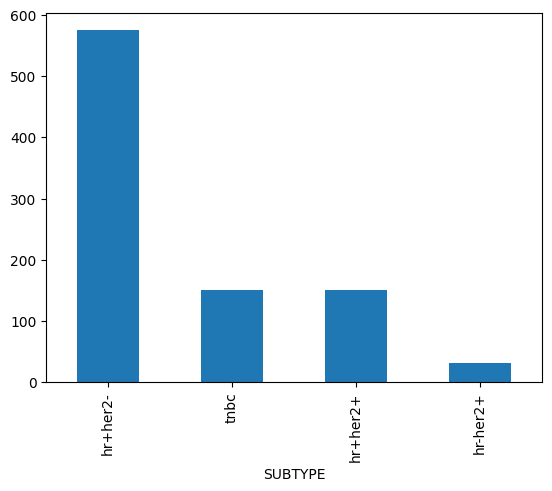

In [37]:
df['SUBTYPE'].value_counts().plot.bar()

In [20]:
def print_column_stats(df: pd.DataFrame, col: str):
	print(df[col].dropna(inplace=False).value_counts(), df[col].isna().sum())
	sns.displot(df[col].dropna(inplace=False))

HER2
0.0    726
1.0    181
Name: count, dtype: int64 0
ER
1.0    711
0.0    196
Name: count, dtype: int64 0
PR
1.0    610
0.0    295
Name: count, dtype: int64 2


HR
1.0    725
0.0    182
Name: count, dtype: int64 0


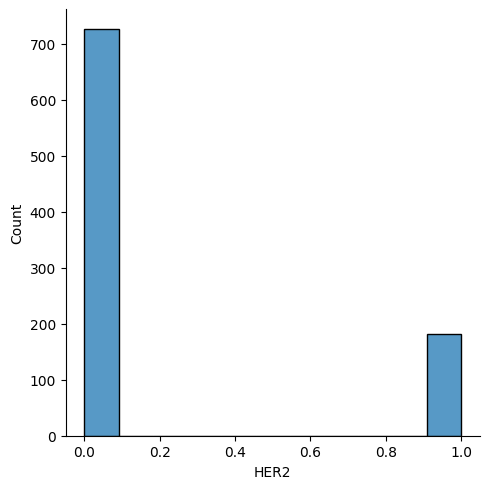

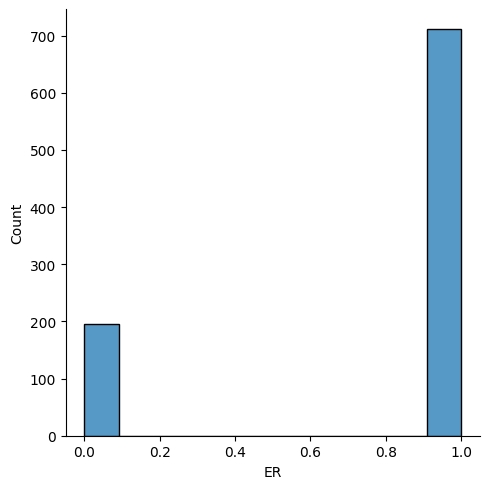

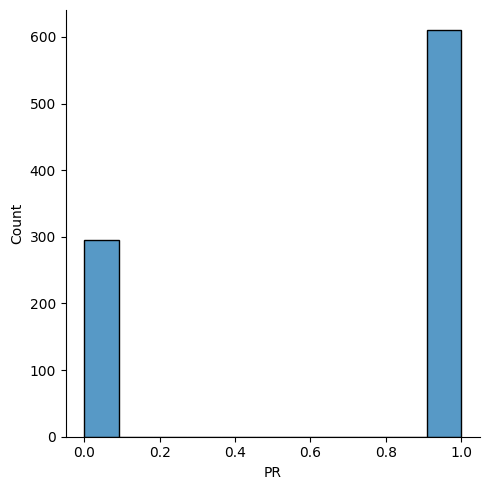

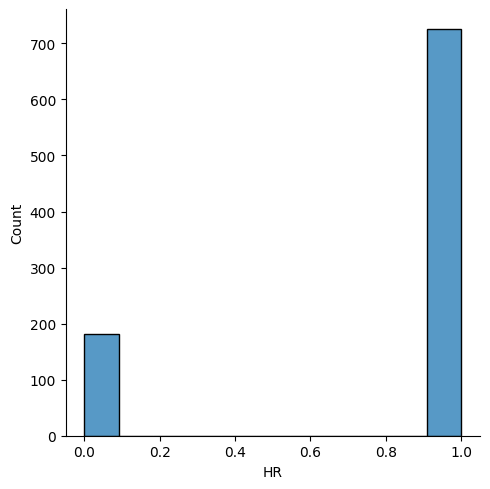

In [21]:
for col in ['HER2', 'ER', 'PR', 'HR']:
    print_column_stats(df, col)

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [23]:
print(bert_model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [24]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=420)

In [25]:
class ExamDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [26]:
train_encodings = tokenizer(train_df['text'].to_list(), truncation=True, padding=True)
val_encodings = tokenizer(val_df['text'].to_list(), truncation=True, padding=True)

In [27]:
train_dataset = ExamDataset(train_encodings, train_df['HER2'])
val_dataset = ExamDataset(val_encodings, val_df['HER2'])

In [28]:
class BertClassifier(nn.Module):
    def __init__(self, bert_model):
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        
        self.linear_pr = nn.Linear(768, 2)
        self.linear_er = nn.Linear(768, 2)
        self.linear_hr = nn.Linear(768, 2)
        self.linear_her = nn.Linear(768, 2)
        
        self.init_weights(self.linear_her)
        self.init_weights(self.linear_hr)
        self.init_weights(self.linear_er)
        self.init_weights(self.linear_pr)

    def init_weights(layer):
        nn.init.normal_(layer, std=0.02)
        nn.init.normal_(layer, 0)
        
    def forward(self, input_ids):
        # get last_hidden_state
        # vec, _ = self.bert(input_ids)
        output = self.bert(input_ids)
        # only get first token 'cls'
        print(output.keys(), output['pooler_output'].shape, output['last_hidden_state'].shape)
        # vec = vec[:,0,:]
        # vec = vec.view(-1, 768)

        pr_logits = self.linear_pr(output['pooler_output'])
        er_logits = self.linear_er(output['pooler_output'])
        hr_logits = self.linear_hr(output['pooler_output'])
        her_logits = self.linear_her(output['pooler_output'])
        
        return F.log_softmax(pr_logits), F.log_softmax(er_logits), F.log_softmax(hr_logits), F.log_softmax(her_logits)

classifier = BertClassifier(bert_model)

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
classifier.to(device)
classifier.train()

loss_function = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
losses = []
optim = AdamW(classifier.parameters(), lr=5e-5)

for epoch in range(3):
    total_loss = 0
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].type(torch.LongTensor).to(device)
        print(labels)
        outputs = classifier(input_ids)
        loss = loss_function(outputs, labels)
        loss.backward()
        optim.step()
        total_loss += loss.item()
    print(total_loss)
    losses.append(total_loss)

classifier.eval()

cuda


/home/swietjak/mgr/env/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_1123/1894353532.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item['labels'] = torch.tensor(self.labels[idx])
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
odict_keys(['last_hidden_state', 'pooler_output']) torch.Size([8, 768]) torch.Size([8, 512, 768])


/tmp/ipykernel_1123/2038581805.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()